In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Create a synthetic dataset (1000 samples, 10 features, 5 informative, 2 redundant, 90% of one class)
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=2, n_clusters_per_class=1, weights=[0.9], flip_y=0, random_state=42)

In [3]:
# Turn dataset into dataframe for usability
df = pd.DataFrame(X, columns=[f'Feat_{i}' for i in range(1, 11)])
df['Target'] = y

df.head()

,Feat_1,Feat_2,Feat_3,Feat_4,Feat_5,Feat_6,Feat_7,Feat_8,Feat_9,Feat_10,Target
0,0.393074,1.870399,-0.233284,-1.295438,-0.142837,1.475733,-0.969051,-0.093910,-1.110957,0.543093,0
1,1.398595,1.485975,1.206587,-0.024771,2.676278,-0.619636,-0.295027,0.982124,0.955856,2.159424,0
2,0.038501,1.106842,0.498605,-2.839004,-3.086502,0.753736,1.746154,1.452008,-2.833326,-0.514634,0
3,1.468521,1.004174,0.510276,-0.251417,3.146824,0.877351,-0.300327,-0.073444,0.356724,2.148308,0
4,2.932286,3.761785,0.777972,-2.891083,-1.699752,-0.170747,-3.071151,5.104681,-0.483350,0.404189,0


In [4]:
# Add some categorical features
df['Feat_6'] = np.random.choice(['A', 'B', 'C'], size=1000)
df['Feat_7'] = np.random.choice(['X', 'Y', 'Z'], size=1000)

df

,Feat_1,Feat_2,Feat_3,Feat_4,Feat_5,Feat_6,Feat_7,Feat_8,Feat_9,Feat_10,Target
0,0.393074,1.870399,-0.233284,-1.295438,-0.142837,A,X,-0.093910,-1.110957,0.543093,0
1,1.398595,1.485975,1.206587,-0.024771,2.676278,A,Y,0.982124,0.955856,2.159424,0
2,0.038501,1.106842,0.498605,-2.839004,-3.086502,A,Y,1.452008,-2.833326,-0.514634,0
3,1.468521,1.004174,0.510276,-0.251417,3.146824,C,Y,-0.073444,0.356724,2.148308,0
4,2.932286,3.761785,0.777972,-2.891083,-1.699752,A,Z,5.104681,-0.483350,0.404189,0
...,...,...,...,...,...,...,...,...,...,...,...
995,0.534176,0.488650,-0.447199,-2.558825,-1.560218,C,Y,1.386999,-2.457993,0.299866,0
996,1.750876,3.358557,1.300249,-2.694066,-2.676383,B,Y,4.496984,-0.886717,0.014379,0
997,-2.616984,-0.196227,-1.580700,1.998400,0.463177,C,Z,0.888948,1.636574,2.008788,1
998,1.127710,1.195102,-0.682311,-0.771141,1.703476,C,Y,0.699901,-0.156657,1.715908,0


In [5]:
# Separate features and target
X = df.drop('Target', axis=1)
y = df['Target']

In [6]:
X.head()

,Feat_1,Feat_2,Feat_3,Feat_4,Feat_5,Feat_6,Feat_7,Feat_8,Feat_9,Feat_10
0,0.393074,1.870399,-0.233284,-1.295438,-0.142837,A,X,-0.093910,-1.110957,0.543093
1,1.398595,1.485975,1.206587,-0.024771,2.676278,A,Y,0.982124,0.955856,2.159424
2,0.038501,1.106842,0.498605,-2.839004,-3.086502,A,Y,1.452008,-2.833326,-0.514634
3,1.468521,1.004174,0.510276,-0.251417,3.146824,C,Y,-0.073444,0.356724,2.148308
4,2.932286,3.761785,0.777972,-2.891083,-1.699752,A,Z,5.104681,-0.483350,0.404189


In [7]:
y.head()

,Target
0,0
1,0
2,0
3,0
4,0


In [8]:
# Check data distribution
print("Pre-SMOTE distribution:", Counter(y))

Pre-SMOTE distribution: Counter({0: 901, 1: 99})


One of the class has 901 instances, however another one only has 99

## Embedded Methods

In [9]:
# Use Random Forest, drop categorical features first to be inputed in Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
X_integer = X.drop(['Feat_6', 'Feat_7'], axis=1)
rf_model.fit(X_integer, y)

# Get important features
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Thresholding
threshold = 0.05
important_features_indices = [i for i in range(len(importances)) if importances[i] >= threshold]

# Show selected features
print("Selected features using Embedded Methods: ")
for i in important_features_indices:
    print(f"{X.columns[i]}: {importances[i]}")

# Get column names
important_features = X_integer.columns[important_features_indices]

# Extract important features and join with categorical features
X_important = X_integer[important_features]
X_Selected = pd.concat([X_important, X['Feat_6']], axis=1)
X_Selected = pd.concat([X_Selected, X['Feat_7']], axis=1)

# Show
X_Selected.head()

Selected features using Embedded Methods: 
Feat_1: 0.4190443236511096
Feat_4: 0.1822932676075951
Feat_5: 0.06887040068093626
Feat_7: 0.1314983869157817
Feat_8: 0.09450201991963915


,Feat_1,Feat_4,Feat_5,Feat_9,Feat_10,Feat_6,Feat_7
0,0.393074,-1.295438,-0.142837,-1.110957,0.543093,A,X
1,1.398595,-0.024771,2.676278,0.955856,2.159424,A,Y
2,0.038501,-2.839004,-3.086502,-2.833326,-0.514634,A,Y
3,1.468521,-0.251417,3.146824,0.356724,2.148308,C,Y
4,2.932286,-2.891083,-1.699752,-0.483350,0.404189,A,Z


## Transform

We need to encode categorical features so Random Forest can use our dataset

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
X_Selected['Feat_6'] = label_encoder.fit_transform(X_Selected['Feat_6'])
X_Selected['Feat_7'] = label_encoder.fit_transform(X_Selected['Feat_7'])

X_Selected.head()

,Feat_1,Feat_4,Feat_5,Feat_9,Feat_10,Feat_6,Feat_7
0,0.393074,-1.295438,-0.142837,-1.110957,0.543093,0,0
1,1.398595,-0.024771,2.676278,0.955856,2.159424,0,1
2,0.038501,-2.839004,-3.086502,-2.833326,-0.514634,0,1
3,1.468521,-0.251417,3.146824,0.356724,2.148308,2,1
4,2.932286,-2.891083,-1.699752,-0.483350,0.404189,0,2


## Handle Outliers

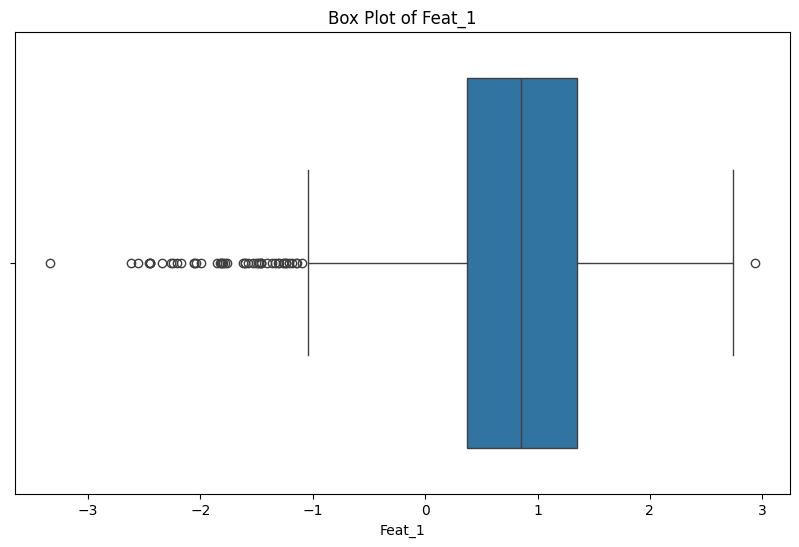

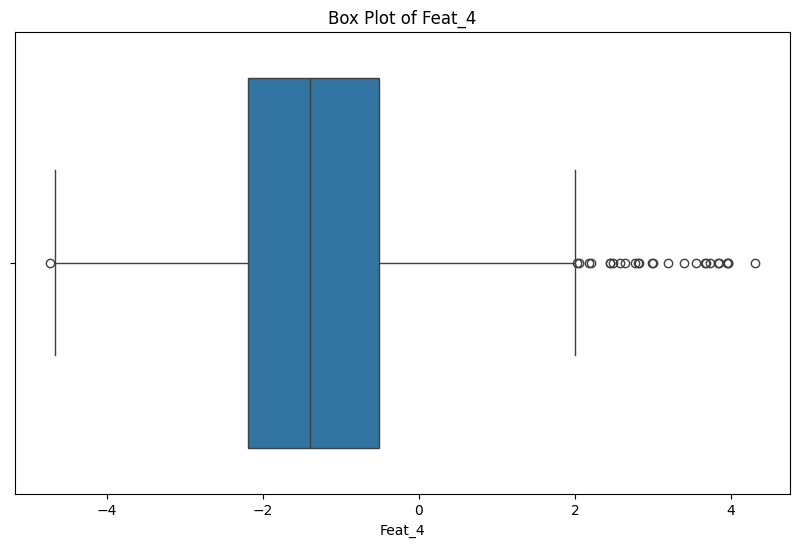

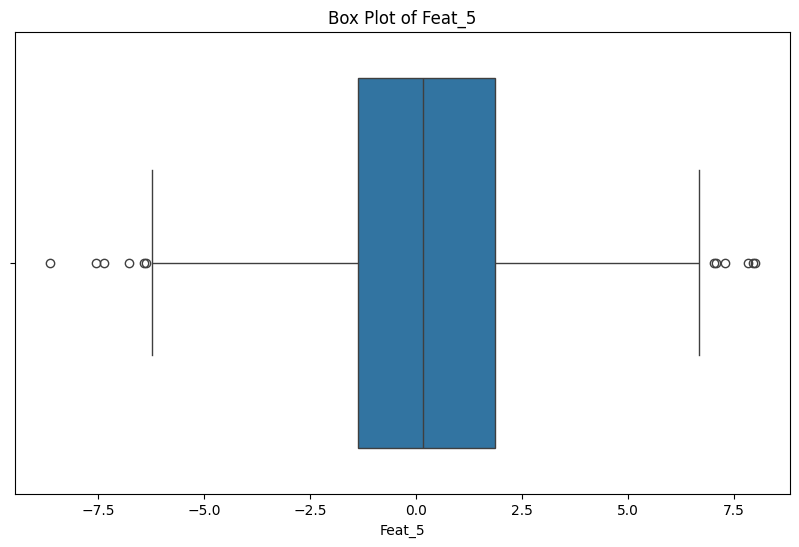

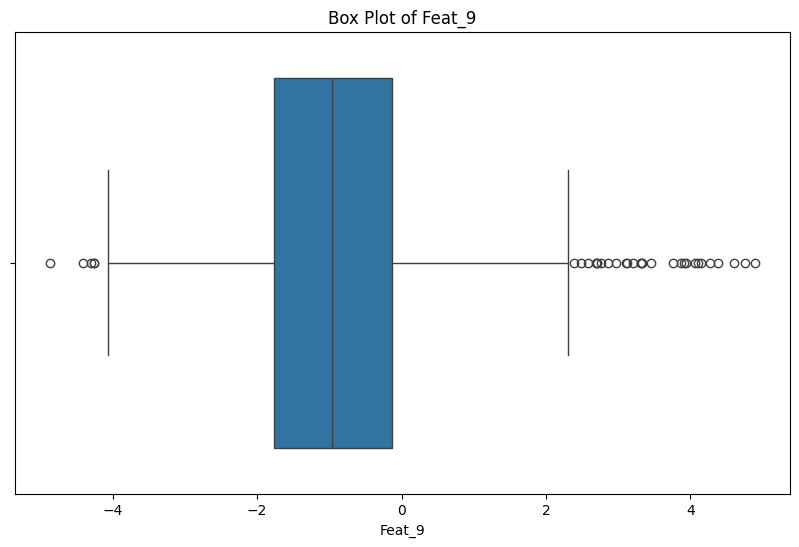

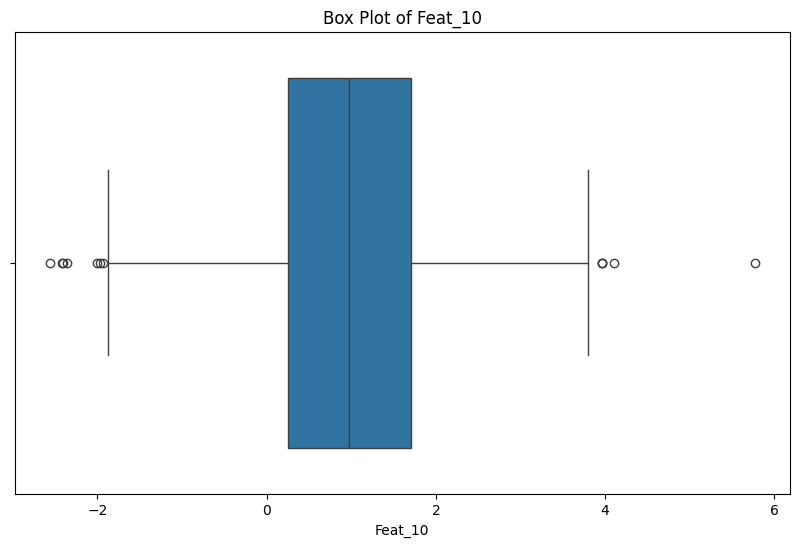

In [11]:
# Check dataset outliers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Select numerical columns
numeric_columns = X_Selected.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.drop(['Feat_6', 'Feat_7'])

# Copy original data
X_cleaned = X_Selected.copy()
X_cleaned = pd.concat([X_cleaned, y], axis=1)

for feature in X_cleaned[numeric_columns]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=X_cleaned[feature])
    plt.title(f'Box Plot of {feature}')
    plt.show()

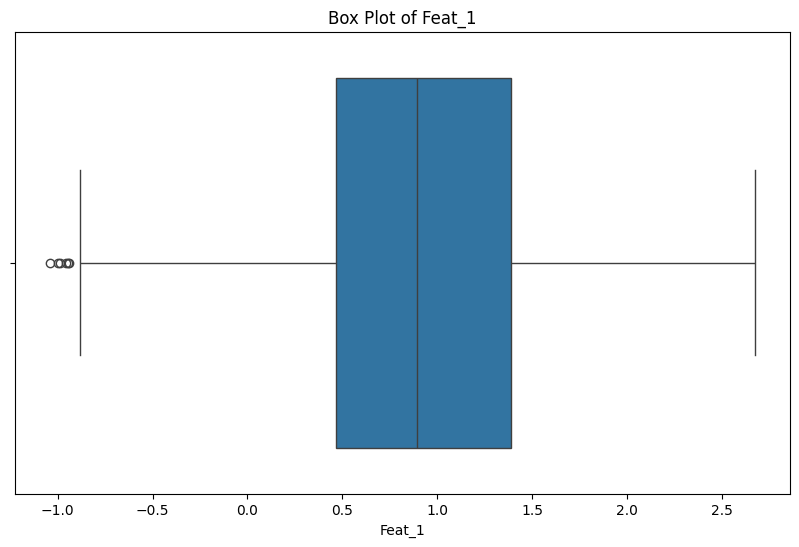

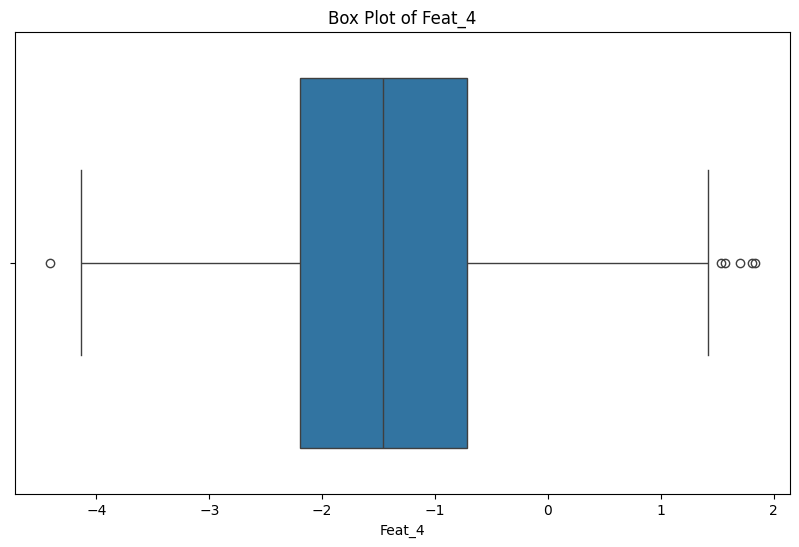

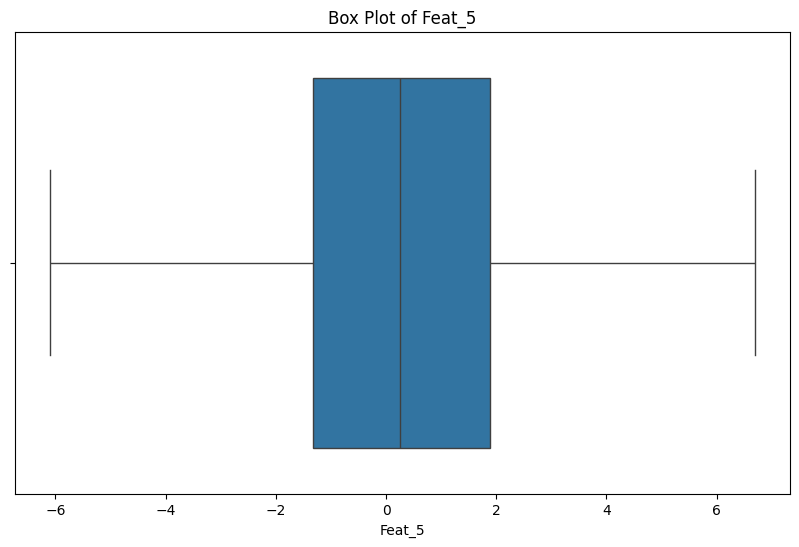

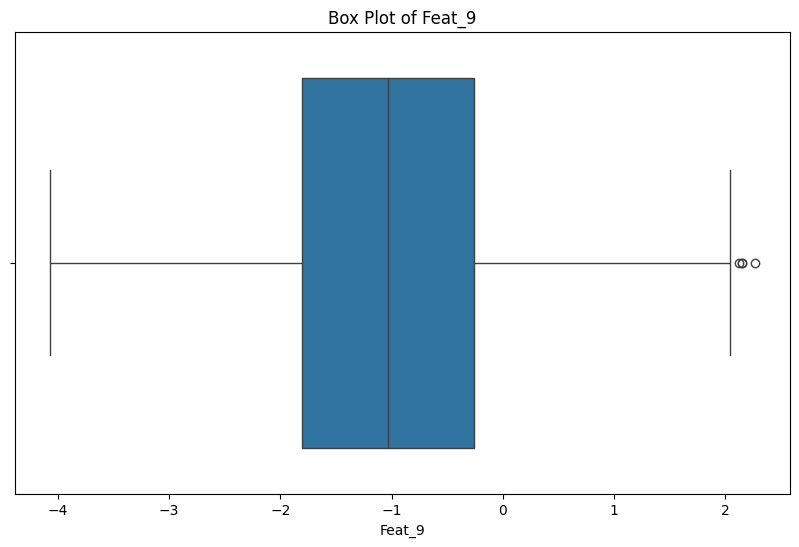

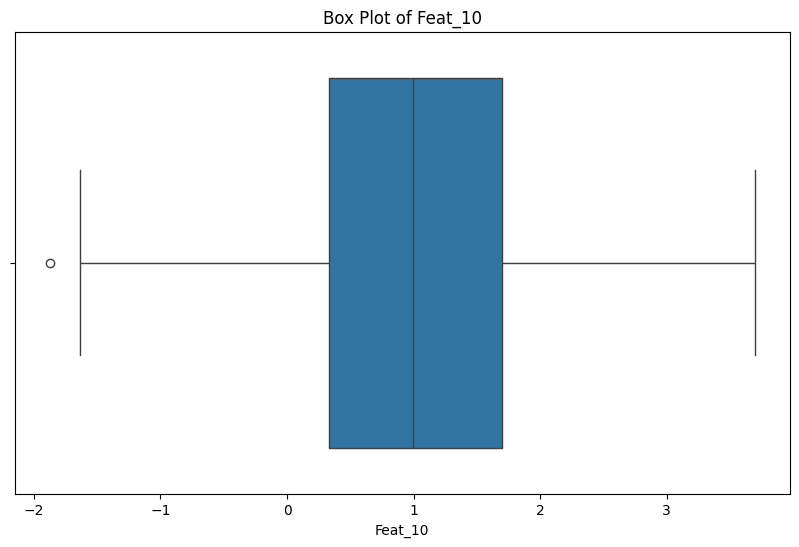

In [12]:
# Delete Outliers
for col in numeric_columns:

    Q1 = X_important[col].quantile(0.25)
    Q3 = X_important[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = X_cleaned[(X_cleaned[col] < lower_bound) | (X_cleaned[col] > upper_bound)]

    X_cleaned = X_cleaned.drop(outliers.index)

for feature in X_cleaned[numeric_columns]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=X_cleaned[feature])
    plt.title(f'Box Plot of {feature}')
    plt.show()

In [13]:
y = X_cleaned['Target']
X_cleaned = X_cleaned.drop('Target', axis=1)

X_cleaned

,Feat_1,Feat_4,Feat_5,Feat_9,Feat_10,Feat_6,Feat_7
0,0.393074,-1.295438,-0.142837,-1.110957,0.543093,0,0
1,1.398595,-0.024771,2.676278,0.955856,2.159424,0,1
2,0.038501,-2.839004,-3.086502,-2.833326,-0.514634,0,1
3,1.468521,-0.251417,3.146824,0.356724,2.148308,2,1
5,1.078172,-3.525758,-3.454547,-2.809018,-0.566425,1,0
...,...,...,...,...,...,...,...
994,1.229365,-1.790008,0.452948,-1.362072,1.016300,2,2
995,0.534176,-2.558825,-1.560218,-2.457993,0.299866,2,1
996,1.750876,-2.694066,-2.676383,-0.886717,0.014379,1,1
998,1.127710,-0.771141,1.703476,-0.156657,1.715908,2,1


## SMOTE

In [14]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Oversample
X_resampled, y_resampled = smote.fit_resample(X_cleaned, y)

# Show distribution
print("Post-SMOTE Distribution:", Counter(y_resampled))

# Turn results to dataframe
X_resampled = pd.DataFrame(X_resampled)
y_resampled = pd.Series(y_resampled, name='Target')

X_resampled

Post-SMOTE Distribution: Counter({0: 884, 1: 884})


,Feat_1,Feat_4,Feat_5,Feat_9,Feat_10,Feat_6,Feat_7
0,0.393074,-1.295438,-0.142837,-1.110957,0.543093,0,0
1,1.398595,-0.024771,2.676278,0.955856,2.159424,0,1
2,0.038501,-2.839004,-3.086502,-2.833326,-0.514634,0,1
3,1.468521,-0.251417,3.146824,0.356724,2.148308,2,1
4,1.078172,-3.525758,-3.454547,-2.809018,-0.566425,1,0
...,...,...,...,...,...,...,...
1763,-0.893187,0.627593,-1.288266,0.884275,-0.184170,0,0
1764,-0.360863,1.455714,2.358506,1.867312,2.021813,0,0
1765,0.183634,-2.140361,2.219453,-2.333251,3.608298,1,0
1766,-0.402202,-0.002626,1.629463,-0.225261,1.697170,0,0


In [15]:
y_resampled

,Target
0,0
1,0
2,0
3,0
4,0
...,...
1763,1
1764,1
1765,1
1766,1


## Scaling

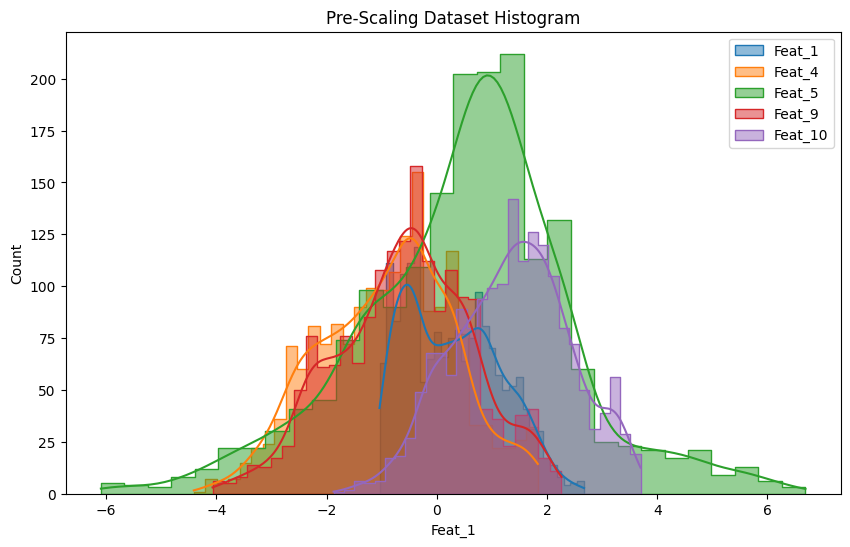

In [16]:
# We won't involve categorical columns here
plt.figure(figsize=(10, 6))
for col in X_resampled[important_features]:
    sns.histplot(X_resampled[col], kde=True, label=col, bins=30, element='step')
plt.title('Pre-Scaling Dataset Histogram')
plt.legend()
plt.show()

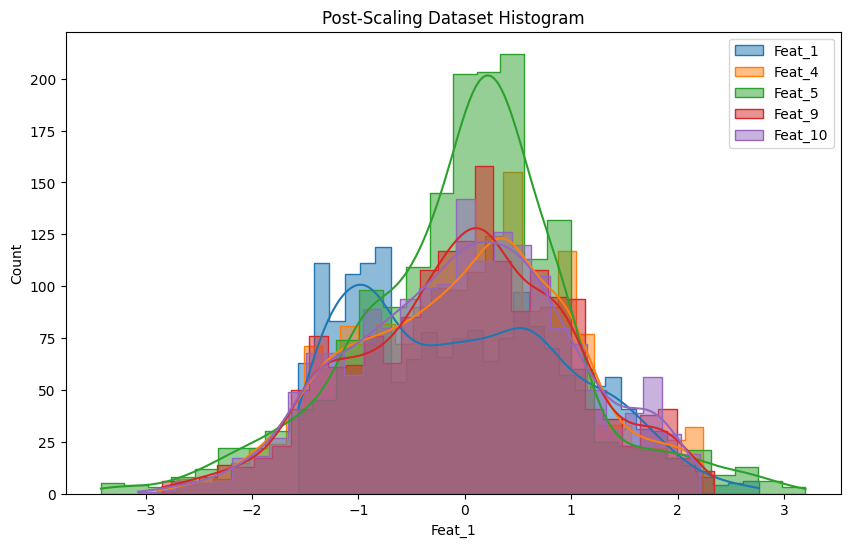

In [17]:
# Standardize
scaler = StandardScaler()
X_resampled[important_features] = scaler.fit_transform(X_resampled[important_features])

plt.figure(figsize=(10, 6))
for col in X_resampled[important_features]:
    sns.histplot(X_resampled[col], kde=True, label=col, bins=30, element='step')
plt.title('Post-Scaling Dataset Histogram')
plt.legend()
plt.show()

In [18]:
# Check dataset quality
X_resampled.describe(include='all')

,Feat_1,Feat_4,Feat_5,Feat_9,Feat_10,Feat_6,Feat_7
count,1.768000e+03,1.768000e+03,1.768000e+03,1.768000e+03,1.768000e+03,1768.000000,1768.000000
mean,-6.430251e-17,-6.430251e-17,-1.607563e-17,-1.286050e-16,-1.929075e-16,0.857466,0.937217
std,1.000283e+00,1.000283e+00,1.000283e+00,1.000283e+00,1.000283e+00,0.777470,0.791877
min,-1.563340e+00,-2.879778e+00,-3.419677e+00,-2.844197e+00,-3.071743e+00,0.000000,0.000000
25%,-8.881142e-01,-7.402487e-01,-5.810969e-01,-6.724159e-01,-7.148799e-01,0.000000,0.000000
50%,-5.486044e-02,8.225840e-02,9.422902e-02,5.543268e-02,4.917850e-02,1.000000,1.000000
75%,7.399171e-01,7.299410e-01,5.519269e-01,7.140111e-01,7.006345e-01,1.000000,2.000000
max,2.760825e+00,2.239603e+00,3.198793e+00,2.336428e+00,2.204621e+00,2.000000,2.000000


## Data Splitting

In [19]:
# Divide dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Show results
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training set shape: X_train=(1414, 7), y_train=(1414,)
Test set shape: X_test=(354, 7), y_test=(354,)


## Model Development

In [20]:
# Define model evaluation function
def evaluate (model, X_test, y_test, name):
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = cm.ravel()

  plt.figure(figsize=(5, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.title(f'{name} Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()
  print(f"True Positive (TP): {tp}")
  print(f"False Positive (FP): {fp}")
  print(f"False Negative (FN): {fn}")
  print(f"True Negative (TN): {tn}")

  print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
  print(f"Precision: {precision_score(y_test, y_pred):.4f}")
  print(f"Recall: {recall_score(y_test, y_pred):.4f}")
  print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

  results = {
      'Confusion Matrix': cm,
      'True Positive (TP)': tp,
      'False Positive (FP)': fp,
      'False Negative (FN)': fn,
      'True Negative (TN)': tn,
      'Accuracy': accuracy_score(y_test, y_pred),
      'Precision': precision_score(y_test, y_pred),
      'Recall': recall_score(y_test, y_pred),
      'F1-Score': f1_score(y_test, y_pred)
    }

  return results

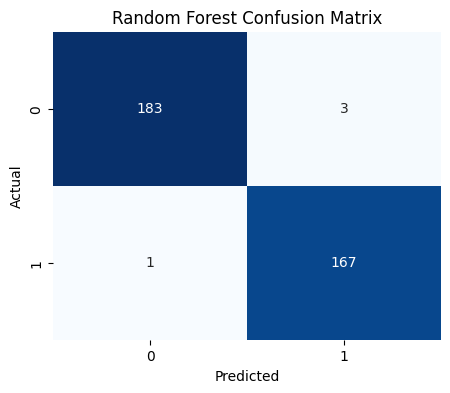

True Positive (TP): 167
False Positive (FP): 3
False Negative (FN): 1
True Negative (TN): 183
Accuracy: 0.9887
Precision: 0.9824
Recall: 0.9940
F1-Score: 0.9882


In [22]:
# Train & Evaluate
rf = RandomForestClassifier().fit(X_train, y_train)
rf_eval = evaluate(rf, X_test, y_test, 'Random Forest')